In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
!pip install split-folders

In [2]:
import splitfolders

In [4]:
splitfolders.ratio(r"G:/Innofuze/MachineLearning/CNN_skin/databse", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 240 files [00:02, 85.99 files/s] 


In [5]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [6]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [7]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output\test
0 folder and 4 images in output\test\Dermatofibroma
0 folder and 4 images in output\test\Melanocyticnevus
0 folder and 4 images in output\test\Melanoma
3 folder and 0 images in output\train
0 folder and 60 images in output\train\Dermatofibroma
0 folder and 60 images in output\train\Melanocyticnevus
0 folder and 60 images in output\train\Melanoma
3 folder and 0 images in output\val
0 folder and 16 images in output\val\Dermatofibroma
0 folder and 16 images in output\val\Melanocyticnevus
0 folder and 16 images in output\val\Melanoma


In [4]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (768, 1024, 3)


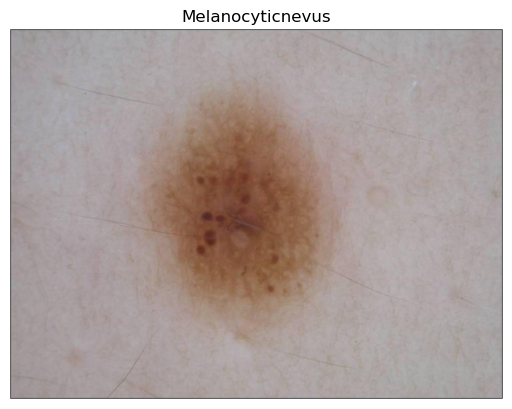

In [5]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Melanocyticnevus')

Image Shape : (450, 600, 3)


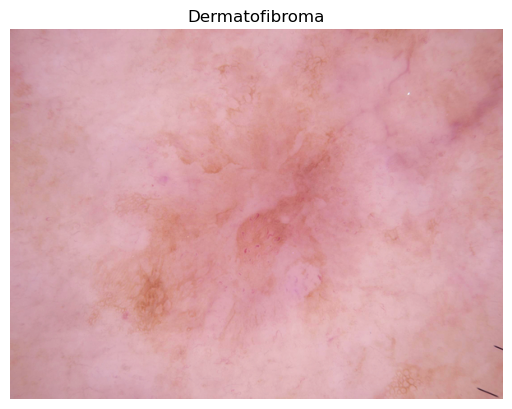

In [6]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Dermatofibroma')

Image Shape : (768, 1024, 3)


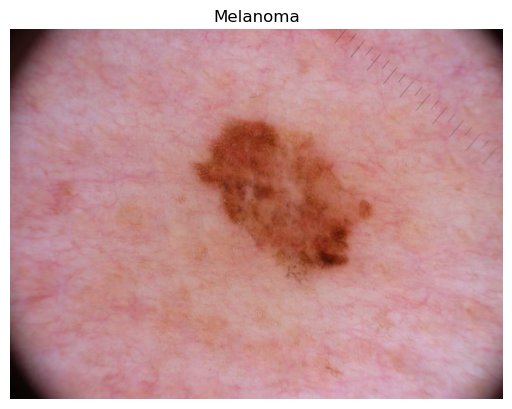

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Melanoma')

In [12]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [13]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 180 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [14]:
train_data.class_indices

{'Dermatofibroma': 0, 'Melanocyticnevus': 1, 'Melanoma': 2}

In [15]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [16]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (180,)
val_y.shape:  (48,)
test_y.shape:  (12,)


In [17]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [18]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=100, validation_data=valid_data)

Epoch 1/25


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.2912 - loss: 1.3022 - val_accuracy: 0.3750 - val_loss: 1.1012
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.3526 - loss: 1.1481 - val_accuracy: 0.3958 - val_loss: 1.0898
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.4006 - loss: 1.1259 - val_accuracy: 0.4792 - val_loss: 1.0077
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.4685 - loss: 1.0752 - val_accuracy: 0.4792 - val_loss: 0.9315
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.5170 - loss: 0.9540 - val_accuracy: 0.5000 - val_loss: 0.8941
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.5877 - loss: 0.8640 - val_accuracy: 0.5000 - val_loss: 0.8639
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.6202 - loss: 0.8745 - val_accuracy: 0.5625 - val_loss: 0.8298
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.5789 - loss: 0.8455 - val_accuracy: 0.5833 - val_loss: 0.8056
Epoch 9/25
3/3 ━━━━

In [24]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

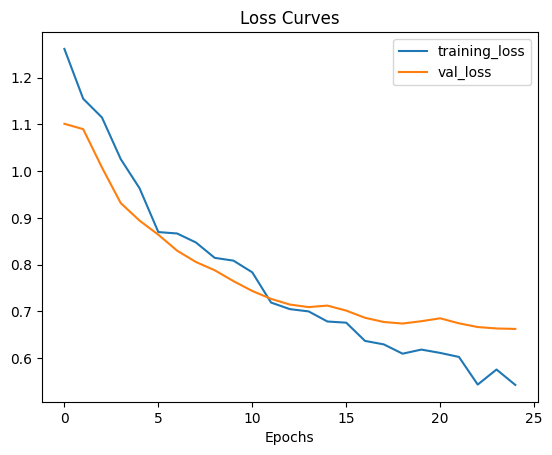

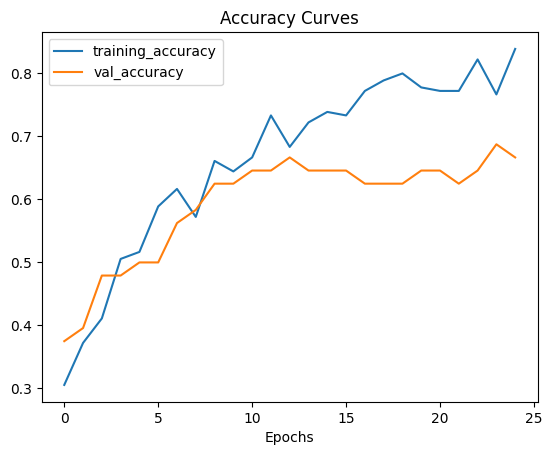

In [25]:
plot_loss_curves(history)

In [26]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.50      0.50      0.50        16
           2       0.56      0.75      0.64        12

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.70      0.67      0.67        48



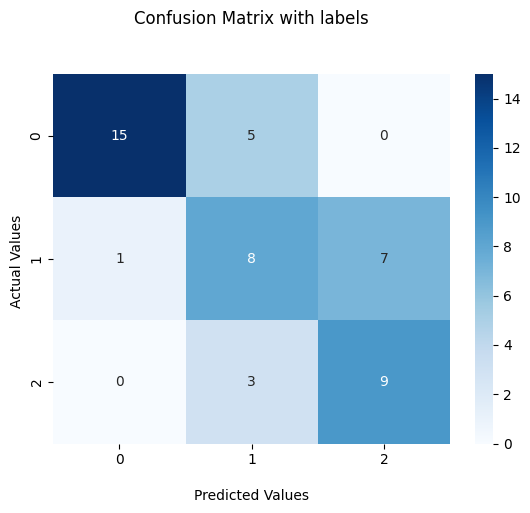

In [27]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.75      0.75      0.75         4
           2       0.00      0.00      0.00         1

    accuracy                           0.58        12
   macro avg       0.58      0.44      0.49        12
weighted avg       0.83      0.58      0.67        12



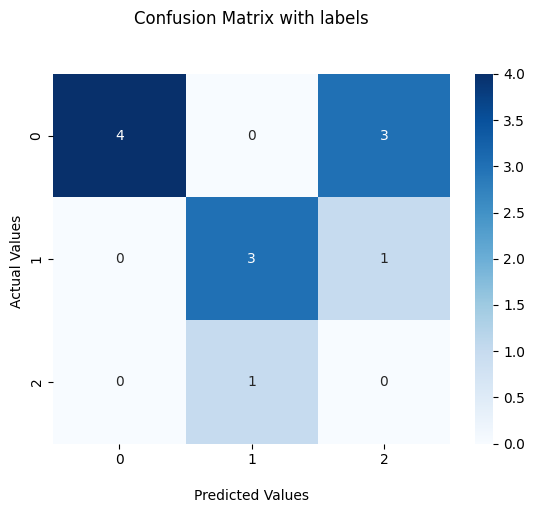

In [29]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [30]:
model.save('my_model.keras')

In [31]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [36]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np
  
from keras.models import load_model
  
model = load_model('my_model.keras')
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\CNN_skin\dataset\Melanocyticnevus\ISIC_0000039_downsampled.jpg"

image = image.load_img(image_path, target_size=(224, 224))
#plt.imshow(image)

img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)
label = model.predict(img)
#print(label)
if label[0][0] > label[0][1]:
    print('Dermatofibroma')
elif label[0][1] > label[0][2]:
    print('Melanocyticnevus')
elif label[0][2] > label[0][3]:
    print('Melanoma')
else:
    print('Enter A vaild image')


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Melanocyticnevus


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Disease : Dermatofibroma


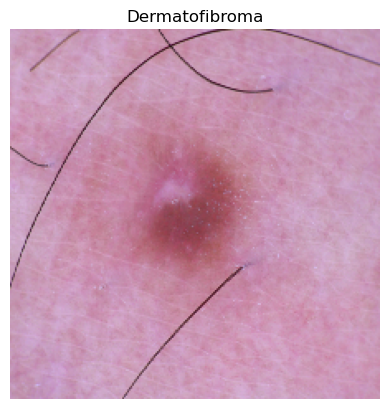

In [8]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SKIN_CANCER_DETECTION\dataset\Dermatofibroma\ISIC_0026417.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Dermatofibroma', 'Melanocyticnevus', 'Melanoma']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Disease :", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\skincancer\databse\Dermatofibroma\ISIC_0024386.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Dermatofibroma', 'Melanocyticnevus', 'Melanoma']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to classify an image
def classify_image():
    # Load the trained model
    model = load_model('my_model.keras')
    
    # Open a dialog box to select an image file
    file_path = filedialog.askopenfilename()
    
    # Load the selected image
    image = Image.open(file_path)
    image = image.resize((224, 224))  # Resize the image to match model input size
    
    # Convert image to numpy array and preprocess
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1, 224, 224, 3)
    
    # Predict the label
    label = model.predict(img)
    
    # Determine the predicted class
    class_names = ['Dermatofibroma', 'Melanocyticnevus', 'Melanoma']
    predicted_class_index = np.argmax(label)
    predicted_class = class_names[predicted_class_index]
    
    # Display the image with the predicted label
    plt.imshow(image)
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()

# Create a Tkinter window
root = tk.Tk()
root.title("Skin Cancer Classifier")

# Create a button to trigger image classification
classify_button = tk.Button(root, text="Classify Image", command=classify_image)
classify_button.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()
